# TReNDS Neuroimaging - Data exploration

## Contents


- <a href='#1'>1. A gentle introduction to MRI</a>  
     - <a href='#1-1'>1.1 What is a MRI?</a>
     - <a href='#1-2'>1.2 One should not confuse MRI, CT scan and X-ray</a>
     - <a href='#1-3'>1.3 How does a MRI actually work?</a>
     - <a href='#1-4'>1.4 How do we translate magnetic fields into an image?</a>
- <a href='#2'>2. Data exploration</a>
     - <a href='#2-1'>2.1 Target distributions</a>
     - <a href='#2-2'>2.2 SBM loadings</a>
     - <a href='#2-3'>2.3 FNC correlation</a>
     - <a href='#2-4'>2.4 Visualizing 3D spatial maps</a>
- <a href='#3'>3. Basic modelling</a>
     - <a href='#3-1'>3.1 Preparing data</a>
     - <a href='#3-2'>3.2 Training</a>
- <a href='#4'>4. Advanced modelling</a>
     - <a href='#4-1'>4.1 Preparing data</a>
     - <a href='#4-2'>4.2 Modelling</a>
     - <a href='#4-3'>4.3 Training</a>
- <a href='#5'>5. Submission</a>

**This kenrel will be a work in progress, and I will keep on updating it as the competition progresses and I gain more insight about the data.**

If you find this kernel useful, please consider upvoting it, it motivates me to write more quality content.

**Sources**: 
- https://www.healthline.com/health/head-mri
- https://kids.frontiersin.org/article/10.3389/frym.2019.00023
- https://www.kaggle.com/soham1024/visualization-using-nilearn
- https://www.kaggle.com/zacktack/data-scientist-journey-neuroimaging-lgbm

**For a deeper understanding**:
- https://www.youtube.com/watch?v=Gpa0Pgsx7SI
- https://www.youtube.com/watch?v=Ok9ILIYzmaY


**Previous competitons**: 
- https://www.kaggle.com/c/mlsp-2014-mri/overview

## <a id='#1'>A gentle introduction to MRI</a>

### <a id='#1-1'>What is a MRI?</a>

The Magnetisc Resonance Imaging (MRI) is non-invasive test that produces detailed images of your brain and brain stem. An MRI machnie creates the images using a magnetic field and radio waves. 

### <a id="#1-2">One should not confound MRI, CT scan and X-ray...</a>

A MRI scan is different from a CT scan or an X-ray in that **it doesn’t use radiation to produce images**. An MRI scan combines images to create **a 3-D picture of your internal structures**, so it’s more effective than other scans at detecting abnormalities in small structures of the brain such as the pituitary gland and brain stem. 

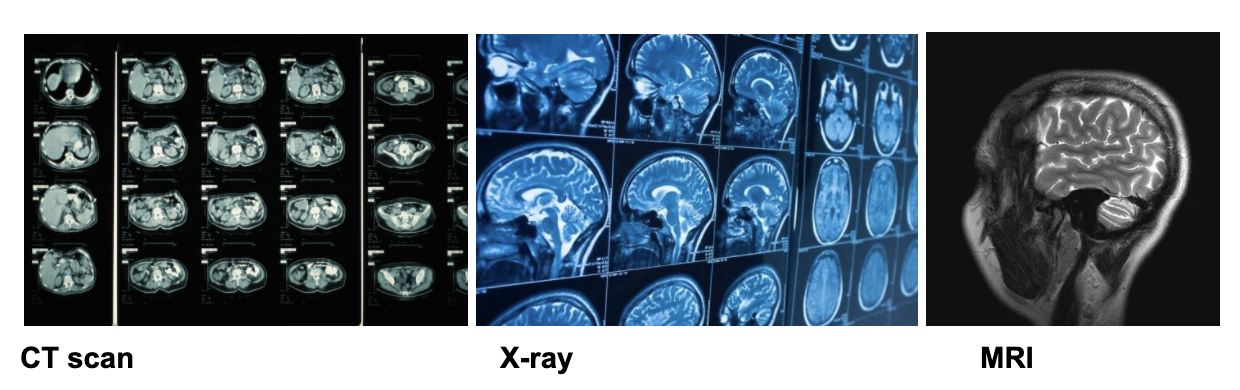

### <a href='#1-3'>How does a MRI actually work?</a>

MRI allows us to see inside the human body with amazing detail, by using magnets and radio waves. The MRI scanner is essentially a giant magnet. MRI uses magnetic fields and radio waves to measure how much water is in different tissues of the body, maps the location of the water and then uses this information to generate a detailed image. The images are so detailed because our bodies are made up of around 65% water, so we have lots of signal to measure.



Water molecule is H2O, meaning it is made up of two hydrogen atoms and one oxygen atom. Looking closer at hydrogen, we see it has central nucleus containing a single proton. Like the Earth spinning on its axis with a north and south magnetic pole, each spinning hydrogen proton is like a tiny magnet that spins around on its own axis. This spinning motion is known as precession. At any moment in time, all the billions of hydrogen protons in our bodies are all in random positions and spinning on their axes. 

However, this randomness changes when we place a human body into a very strong magnetic field, like an MRI scanner. We call the scanners magnetic field the B0 field. The hydrogen protons do not physically move in your body when you enter an MRI scanner, their axes just align along the direction of the B0 field. Some will align “up” (parallel) and some will align “down” (anti-parallel), while still spinning around on their own axes. Due to the law of quantum physics, there are always just slightly more “up” protons than “down.” If you now think about the total magnet field generated from all our hydrogen protons, these tiny magnets almost cancel each other out, to leave only the magnetic field from the small proportion of extra “up” protons, and it is this small magnetic field that we can measure using MRI.

We use something called a radio frequency (RF) pulse, to disturb or flip all the protons, at the same time, out of alignment from the scanner's magnetic field. The frequency of the RF pulse must be the same as the frequency of the spinning hydrogen protons, so they can exchange energy, so that they are in resonance with each other. Resonance enables the protons to absorb enough energy from the RF pulse to rotate their axes away from the B0 field, so that the MRI scanner can measure it. 


#### If the whole body is full of hydrogen “up” protons all spinning at the same precessing frequency in the B0, how do we target just the ones in the brain to investigate mental health? 

We use the fact that the precessional frequency of the protons is dependant on the magnetic field strength. We apply a second magnetic field, B1 that varies across the body. In the example shown in hydrogen protons in the head will then be spinning faster than those in the chest, stomach and feet. Then, we tune the RF pulse to the precessing frequency of the hydrogen protons in the head. The RF pulse will then only be resonant with the protons in the brain. Therefore, only the protons in the brain will absorb energy from the RF pulse and be flipped away from the B0 field. We can obviously tune our RF pulse to be resonant with protons in other parts of the body, like the feet, if we were interested in imaging the feet!

### <a href='#1-4'>How do we translate magnetic fields into an image?</a>

When the RF pulse is turned off, the protons flip back and realign along the main magnetic field, B0. As the protons flip back and realign with B0, they give off energy. Different tissues in the body give off different amounts of energy. To measure this emitted energy, we require some special equipment (called a coil) that is placed around the body part we are imaging. The coil acts as an antenna and detects the released energy as an electrical current. The electrical current is transformed via a Fourier transform. Because protons in the different kinds of tissues in the brain, such as gray matter, white matter and blood, all give off different amounts of energy, the result of the transformed energy is a highly detailed image of the tissue inside the brain.

## <a href='#2'>Data exploration</a>

As you know, the data is multimodal, meaning that multiple features can be fed to a machine learning model. In addition to the MRI images, we are given several additional features to increase our model performance.

In [1]:
# Importing dependencies

from sklearn.model_selection import KFold, train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import joypy

from tqdm.notebook import tqdm
from glob import glob
import gc

import nilearn as nl
import nilearn.plotting as nlplt
import nibabel as nib

import h5py

import lightgbm as lgb

from scipy.stats import skew, kurtosis

import os, random

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

from tensorflow.keras.utils import Sequence

In [2]:
# Loading train scores

MAIN_DATA_PATH = '/media/hiroki/share/kaggle_data/trends-assessment-prediction/'

train_scores_df = pd.read_csv(MAIN_DATA_PATH + 'train_scores.csv')
icn_numbers_df = pd.read_csv(MAIN_DATA_PATH + 'ICN_numbers.csv')
loading_df = pd.read_csv(MAIN_DATA_PATH + 'loading.csv')
fnc_df = pd.read_csv(MAIN_DATA_PATH + 'fnc.csv')
svd_df = pd.read_csv(MAIN_DATA_PATH + 'image_svd_features.csv')

### <a href='#2-1'>Target distributions</a>

The train_scores.csv file contains the targets that we need to predict.

In [3]:
train_scores_df.head()

Id        age  domain1_var1  domain1_var2  domain2_var1  domain2_var2
0  10001  57.436077     30.571975     62.553736     53.325130     51.427998
1  10002  59.580851     50.969456     67.470628     60.651856     58.311361
2  10004  71.413018     53.152498     58.012103     52.418389     62.536641
3  10005  66.532630           NaN           NaN     52.108977     69.993075
4  10007  38.617381     49.197021     65.674285     40.151376     34.096421

Text(0.5, 0.98, 'Target distributions')

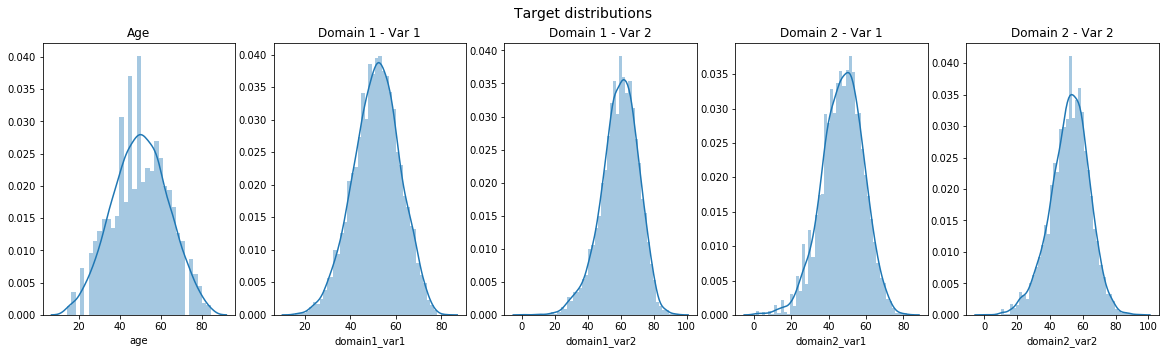

In [4]:
# Plot the distribution of the target variables

fig, ax = plt.subplots(1, 5, figsize=(20, 5))

sns.distplot(train_scores_df['age'], ax=ax[0])
ax[0].set_title('Age')

sns.distplot(train_scores_df['domain1_var1'], ax=ax[1])
ax[1].set_title('Domain 1 - Var 1')

sns.distplot(train_scores_df['domain1_var2'], ax=ax[2])
ax[2].set_title('Domain 1 - Var 2')

sns.distplot(train_scores_df['domain2_var1'], ax=ax[3])
ax[3].set_title('Domain 2 - Var 1')

sns.distplot(train_scores_df['domain2_var2'], ax=ax[4])
ax[4].set_title('Domain 2 - Var 2')

fig.suptitle('Target distributions', fontsize=14)

The distributions are bell-shaped. Age and domain 2 variables seems to have a slight skew. Furthermore, the kurtosis is small, meaning that there is not much weight in the tails.

In [5]:
# Compute statistics

print("Kurtosis (Fisher's definition)")
train_scores_df.kurtosis()

Kurtosis (Fisher's definition)


Id             -1.209817
age            -0.362580
domain1_var1   -0.151687
domain1_var2    0.504195
domain2_var1    0.330433
domain2_var2    0.333461
dtype: float64

Indeed, the target variables are normally-distributed. Note that Fisher's definition means that the kurtosis of a Gaussian distribution is 0.

In [6]:
round(train_scores_df.isna().sum() / len(train_scores_df) * 100, 2)

Id              0.00
age             0.00
domain1_var1    7.45
domain1_var2    7.45
domain2_var1    0.66
domain2_var2    0.66
dtype: float64

Around 7.5% of domain1_var1 and domain1_var2 are missing. An appropriate pre-processing needs to be tested. We can either drop them (not the best strategy, since we have only 5000-odd samples) or use the mean or the column (the option we choose here).

In [7]:
train_scores_df.fillna(train_scores_df.mean(), inplace=True)

Always double-check your work...

In [8]:
train_scores_df.isna().sum()

Id              0
age             0
domain1_var1    0
domain1_var2    0
domain2_var1    0
domain2_var2    0
dtype: int64

### <a href='#2-2'>SBM loadings</a>

Per the competition documentation,

> The first set of features are source-based morphometry (SBM) loadings. These are subject-level weights from a group-level ICA (independent component analysis) decomposition of gray matter concentration maps from structural MRI (sMRI) scans.

In [15]:
loading_df.head()

Id     IC_01     IC_07     IC_05     IC_16     IC_26     IC_06  \
0  10001  0.006070  0.014466  0.004136  0.000658 -0.002742  0.005033   
1  10002  0.009087  0.009291  0.007049 -0.002076 -0.002227  0.004605   
2  10003  0.008151  0.014684  0.010444 -0.005293 -0.002913  0.015042   
3  10004  0.004675  0.000957  0.006154 -0.000429 -0.001222  0.011755   
4  10005 -0.000398  0.006878  0.009051  0.000369  0.000336  0.010679   

      IC_10     IC_09     IC_18  ...     IC_08     IC_03     IC_21     IC_28  \
0  0.016720  0.003484  0.001797  ...  0.018246  0.023711  0.009177 -0.013929   
1  0.012277  0.002946  0.004086  ...  0.014635  0.022556  0.012004 -0.011814   
2  0.017745  0.003930 -0.008021  ...  0.019565  0.030616  0.018184 -0.010469   
3  0.013010  0.000193  0.008075  ...  0.002658  0.022266  0.005956 -0.010595   
4  0.010352  0.003637  0.004180  ...  0.009702  0.017257  0.005454 -0.008591   

      IC_11     IC_20     IC_30     IC_22     IC_29     IC_14  
0  0.030696  0.010496  0.002892 -0.023235  0.022177  0.017192  
1  0.022479  0.005739  0.002880 -0.016609  0.025543  0.014524  
2  0.029799  0.015435  0.005211 -0.028882  0.031427  0.018164  
3  0.024078 -0.000319  0.005866 -0.015182  0.024476  0.014760  
4  0.019416  0.000786  0.002692 -0.019814  0.017105  0.013316  

[5 rows x 27 columns]

<Figure size 1280x800 with 0 Axes>

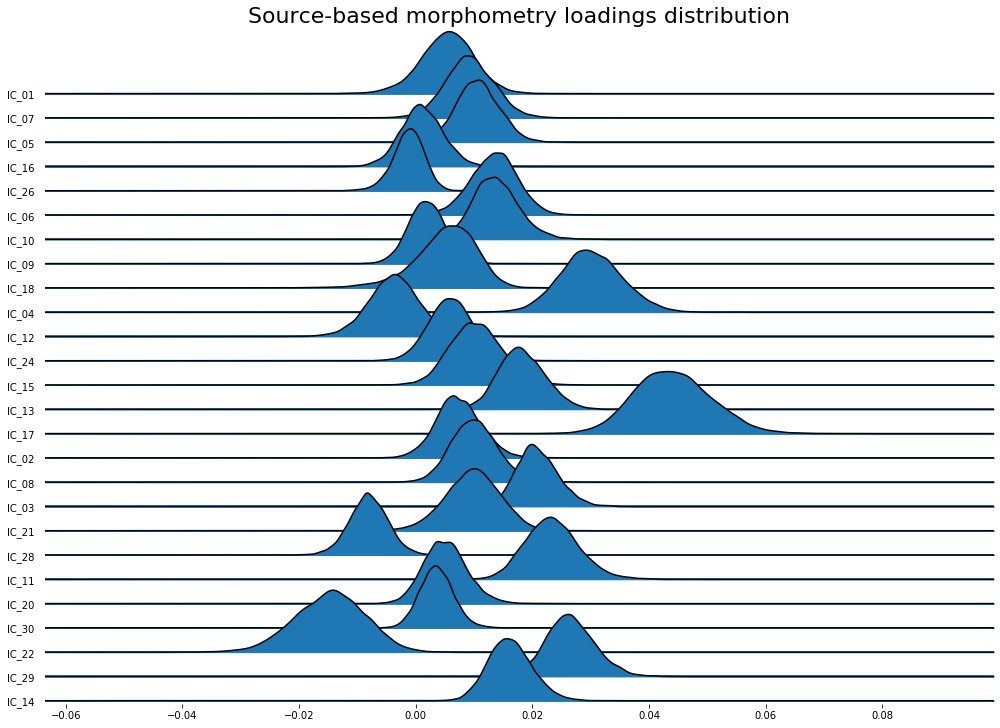

In [10]:
targets = loading_df.columns[1:]

plt.figure(figsize=(16,10), dpi= 80)
fig, axes = joypy.joyplot(loading_df, column=list(targets), ylim='own', figsize=(14,10))

# Decoration
plt.title('Source-based morphometry loadings distribution', fontsize=22)
plt.show()

Let's know build our training set composed of multiple sets of features.

In [11]:
features_df = pd.merge(train_scores_df, loading_df, on=['Id'], how='left')
features_df.head()

Id        age  domain1_var1  domain1_var2  domain2_var1  domain2_var2  \
0  10001  57.436077     30.571975     62.553736     53.325130     51.427998   
1  10002  59.580851     50.969456     67.470628     60.651856     58.311361   
2  10004  71.413018     53.152498     58.012103     52.418389     62.536641   
3  10005  66.532630     51.474692     59.244132     52.108977     69.993075   
4  10007  38.617381     49.197021     65.674285     40.151376     34.096421   

      IC_01     IC_07     IC_05     IC_16  ...     IC_08     IC_03     IC_21  \
0  0.006070  0.014466  0.004136  0.000658  ...  0.018246  0.023711  0.009177   
1  0.009087  0.009291  0.007049 -0.002076  ...  0.014635  0.022556  0.012004   
2  0.004675  0.000957  0.006154 -0.000429  ...  0.002658  0.022266  0.005956   
3 -0.000398  0.006878  0.009051  0.000369  ...  0.009702  0.017257  0.005454   
4  0.005192  0.010585  0.012160 -0.000920  ...  0.006218  0.017332  0.016791   

      IC_28     IC_11     IC_20     IC_30     IC_22     IC_29     IC_14  
0 -0.013929  0.030696  0.010496  0.002892 -0.023235  0.022177  0.017192  
1 -0.011814  0.022479  0.005739  0.002880 -0.016609  0.025543  0.014524  
2 -0.010595  0.024078 -0.000319  0.005866 -0.015182  0.024476  0.014760  
3 -0.008591  0.019416  0.000786  0.002692 -0.019814  0.017105  0.013316  
4 -0.009594  0.019757  0.003731  0.000733 -0.008462  0.026733  0.014358  

[5 rows x 32 columns]

Since we still have relatively few features, let's investigate the correlation between target variables and features.

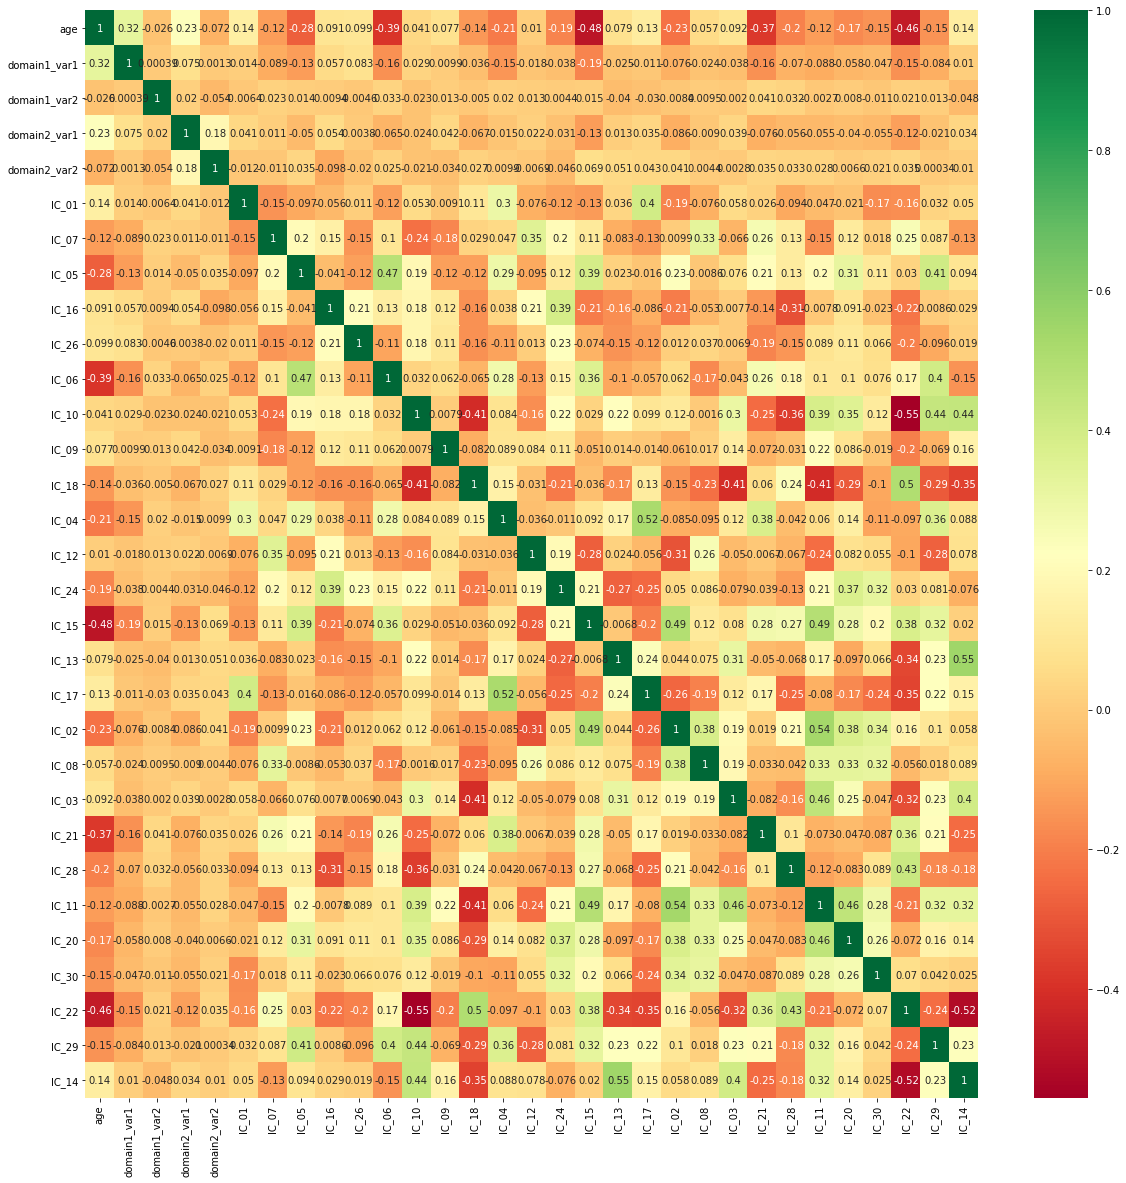

In [13]:
fig, ax = plt.subplots(figsize=(20, 20))
cols = features_df.columns[1:]
sns.heatmap(features_df[cols].corr(), annot=True, cmap='RdYlGn', ax=ax)

### <a href='#2-3'>FNC correlation</a>

This dataframe contains static FNC correlation features for both train and test samples.

As given in the competition data summary,

> The second set are static functional network connectivity (FNC) matrices. These are the subject-level cross-correlation values among 53 component timecourses estimated from group inform guided ICA of resting state functional MRI.

#### What are functional network connectivity matrices?

Functional connectivity is the **connectivity between brain regions that share functional properties**. More specifically, it can be defined as the temporal correlation between spatially remote neurophysiological events, expressed as deviation from statistical independence across these events in distributed neuronal groups and areas. This applies to both resting state and task-state studies. While functional connectivity can refer to correlations across subjects, runs, blocks, trials, or individual time points, resting state functional connectivity focuses on connectivity assessed across individual BOLD time points during resting conditions. Functional connectivity has also been evaluated using the perfusion time series sampled with arterial spin labeled perfusion fMRI.

Source: https://en.wikipedia.org/wiki/Resting_state_fMRI#Functional

In [14]:
fnc_df.head()

Id  SCN(53)_vs_SCN(69)  SCN(98)_vs_SCN(69)  SCN(99)_vs_SCN(69)  \
0  10001            0.368580            0.166876            0.438148   
1  10002            0.151696           -0.024819            0.217504   
2  10003            0.343415            0.109974            0.741641   
3  10004            0.132793            0.258255            0.490769   
4  10005            0.291921            0.251254            0.416470   

   SCN(45)_vs_SCN(69)  ADN(21)_vs_SCN(69)  ADN(56)_vs_SCN(69)  \
0            0.341007           -0.186251            0.049096   
1            0.418072           -0.227234           -0.064052   
2            0.578558           -0.676446           -0.436960   
3            0.342717            0.091112            0.107969   
4            0.511719           -0.362626           -0.164710   

   SMN(3)_vs_SCN(69)  SMN(9)_vs_SCN(69)  SMN(2)_vs_SCN(69)  ...  \
0           0.121417          -0.174268          -0.231578  ...   
1          -0.143832          -0.118116          -0.054825  ...   
2          -0.295663          -0.377790          -0.344963  ...   
3           0.029220          -0.026237           0.094742  ...   
4          -0.289059          -0.015537          -0.087316  ...   

   CBN(13)_vs_DMN(94)  CBN(18)_vs_DMN(94)  CBN(4)_vs_DMN(94)  \
0           -0.149279            0.552841           0.131046   
1           -0.214216           -0.039792           0.143014   
2           -0.154941            0.136850          -0.022361   
3           -0.130339            0.309540           0.141469   
4           -0.139525            0.394932           0.040443   

   CBN(7)_vs_DMN(94)  CBN(18)_vs_CBN(13)  CBN(4)_vs_CBN(13)  \
0           0.335446            0.394867          -0.042853   
1          -0.189962            0.498373           0.444231   
2           0.137625            0.677972           0.409412   
3           0.030853            0.344394           0.214097   
4           0.428334            0.498837           0.266755   

   CBN(7)_vs_CBN(13)  CBN(4)_vs_CBN(18)  CBN(7)_vs_CBN(18)  CBN(7)_vs_CBN(4)  
0           0.124627          -0.060712           0.515964          0.290488  
1           0.592438           0.028649           0.705524          0.248327  
2           0.563892           0.438684           0.618204          0.284474  
3           0.317556           0.012435           0.665937          0.081358  
4           0.227379           0.028984           0.752343          0.087898  

[5 rows x 1379 columns]

In [12]:
# No NaN values in the DataFrame

fnc_df.isna().sum().sum()

0

In [12]:
features_df = pd.merge(features_df, fnc_df, how='left', on='Id')
features_df.head()

Id        age  domain1_var1  domain1_var2  domain2_var1  domain2_var2  \
0  10001  57.436077     30.571975     62.553736     53.325130     51.427998   
1  10002  59.580851     50.969456     67.470628     60.651856     58.311361   
2  10004  71.413018     53.152498     58.012103     52.418389     62.536641   
3  10005  66.532630     51.474692     59.244132     52.108977     69.993075   
4  10007  38.617381     49.197021     65.674285     40.151376     34.096421   

      IC_01     IC_07     IC_05     IC_16  ...  CBN(13)_vs_DMN(94)  \
0  0.006070  0.014466  0.004136  0.000658  ...           -0.149279   
1  0.009087  0.009291  0.007049 -0.002076  ...           -0.214216   
2  0.004675  0.000957  0.006154 -0.000429  ...           -0.130339   
3 -0.000398  0.006878  0.009051  0.000369  ...           -0.139525   
4  0.005192  0.010585  0.012160 -0.000920  ...           -0.150218   

   CBN(18)_vs_DMN(94)  CBN(4)_vs_DMN(94)  CBN(7)_vs_DMN(94)  \
0            0.552841           0.131046           0.335446   
1           -0.039792           0.143014          -0.189962   
2            0.309540           0.141469           0.030853   
3            0.394932           0.040443           0.428334   
4            0.408926           0.072004           0.157582   

   CBN(18)_vs_CBN(13)  CBN(4)_vs_CBN(13)  CBN(7)_vs_CBN(13)  \
0            0.394867          -0.042853           0.124627   
1            0.498373           0.444231           0.592438   
2            0.344394           0.214097           0.317556   
3            0.498837           0.266755           0.227379   
4            0.532046           0.355448           0.462675   

   CBN(4)_vs_CBN(18)  CBN(7)_vs_CBN(18)  CBN(7)_vs_CBN(4)  
0          -0.060712           0.515964          0.290488  
1           0.028649           0.705524          0.248327  
2           0.012435           0.665937          0.081358  
3           0.028984           0.752343          0.087898  
4           0.161005           0.703679          0.293607  

[5 rows x 1410 columns]

# SVD image

In [16]:
features_df = pd.merge(features_df, svd_df, how='left', on='Id')
features_df.head()

Id        age  domain1_var1  domain1_var2  domain2_var1  domain2_var2  \
0  10001  57.436077     30.571975     62.553736     53.325130     51.427998   
1  10002  59.580851     50.969456     67.470628     60.651856     58.311361   
2  10004  71.413018     53.152498     58.012103     52.418389     62.536641   
3  10005  66.532630     51.474692     59.244132     52.108977     69.993075   
4  10007  38.617381     49.197021     65.674285     40.151376     34.096421   

      IC_01     IC_07     IC_05     IC_16  ...  IC50_sv_2   IC51_sv_0  \
0  0.006070  0.014466  0.004136  0.000658  ... -17.799738  166.031494   
1  0.009087  0.009291  0.007049 -0.002076  ...   0.709199  163.013239   
2  0.004675  0.000957  0.006154 -0.000429  ...  -9.008883  192.778342   
3 -0.000398  0.006878  0.009051  0.000369  ...  12.041737  178.219454   
4  0.005192  0.010585  0.012160 -0.000920  ...   5.134978  180.179770   

   IC51_sv_1  IC51_sv_2   IC52_sv_0  IC52_sv_1  IC52_sv_2   IC53_sv_0  \
0   7.140522  -1.852221  162.160387  -7.110113 -13.135310  174.460828   
1  17.676404   5.821980  143.393550  -2.938574 -11.616378  160.541908   
2  -3.093821  -3.798846  175.548164  28.353885   2.312814  179.837870   
3  -8.466525  -8.717311  170.123615  -6.417135  -4.948467  180.774590   
4  15.868681   4.476608  159.916263   1.243108  -1.608821  179.713214   

   IC53_sv_1  IC53_sv_2  
0 -42.337720 -12.991372  
1  -4.967370  12.948171  
2  26.207981 -35.805791  
3 -21.734257  -1.682869  
4 -30.641977  -4.577734  

[5 rows x 1569 columns]

### <a href='#2-4'>Visualizing 3D spatial maps</a>

Credits to: https://www.kaggle.com/soham1024/visualization-using-nilearn

In [17]:
!wget https://github.com/Chaogan-Yan/DPABI/raw/master/Templates/ch2better.nii

--2020-05-11 14:21:49--  https://github.com/Chaogan-Yan/DPABI/raw/master/Templates/ch2better.nii
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Chaogan-Yan/DPABI/master/Templates/ch2better.nii [following]
--2020-05-11 14:21:49--  https://raw.githubusercontent.com/Chaogan-Yan/DPABI/master/Templates/ch2better.nii
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35193272 (34M) [application/octet-stream]
Saving to: ‘ch2better.nii’

ch2better.nii       100%[===================>]  33.56M   137MB/s    in 0.2s    

2020-05-11 14:21:50 (137 MB/s) - ‘ch2better.nii’ saved [35193272/35193272]



In [18]:
mask_filename = '../input/trends-assessment-prediction/fMRI_mask.nii'
smri_filename = 'ch2better.nii'

mask_niimg = nl.image.load_img(mask_filename)

def load_subject(filename, mask_niimg):
    subject_data = None
    
    with h5py.File(filename, 'r') as f:
        subject_data = f['SM_feature'][()]
        
    subject_data = np.moveaxis(subject_data, [0, 1, 2, 3], [3, 2, 1, 0])
    subject_niimg = nl.image.new_img_like(mask_niimg, subject_data, affine=mask_niimg.affine, copy_header=True)
    
    return subject_niimg 

In [19]:
fMRI_train_data_path = '../input/trends-assessment-prediction/fMRI_train/'
filenames = random.choices(os.listdir(fMRI_train_data_path), k=4)

Using soham1024's function, we change the dimensions of the 4d array that is in the Matlab file. We flip the axes such that the first two axes are the width and height.

Image shape is (53, 63, 52, 53)
Detected 53 spatial maps


/opt/conda/lib/python3.6/site-packages/nilearn/plotting/displays.py:99: UserWarning: linewidths is ignored by contourf
  **kwargs)
/opt/conda/lib/python3.6/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


Image shape is (53, 63, 52, 53)
Detected 53 spatial maps
Image shape is (53, 63, 52, 53)
Detected 53 spatial maps
Image shape is (53, 63, 52, 53)
Detected 53 spatial maps


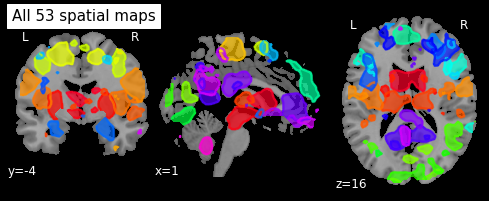

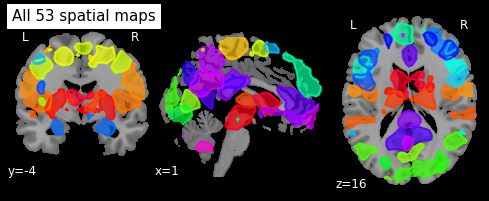

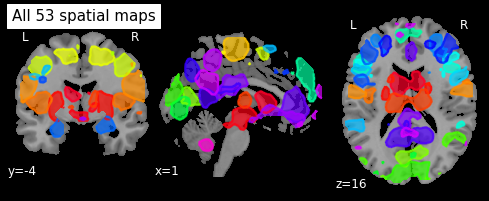

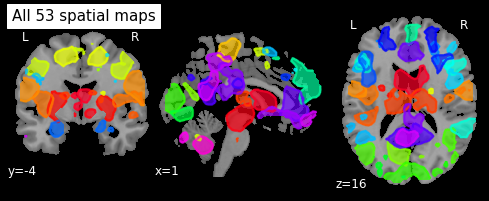

In [20]:
for filename in filenames:
    subject_filename = os.path.join(fMRI_train_data_path, filename)
    subject_niimg = load_subject(subject_filename, mask_niimg)

    print("Image shape is %s" % (str(subject_niimg.shape)))
    num_components = subject_niimg.shape[-1]
    print("Detected {num_components} spatial maps".format(num_components=num_components))

    nlplt.plot_prob_atlas(subject_niimg, 
                          bg_img=smri_filename,
                          view_type='filled_contours',
                          draw_cross=False,
                          title='All %d spatial maps' % num_components,
                          threshold='auto')

#### Visualize independent components (IC)

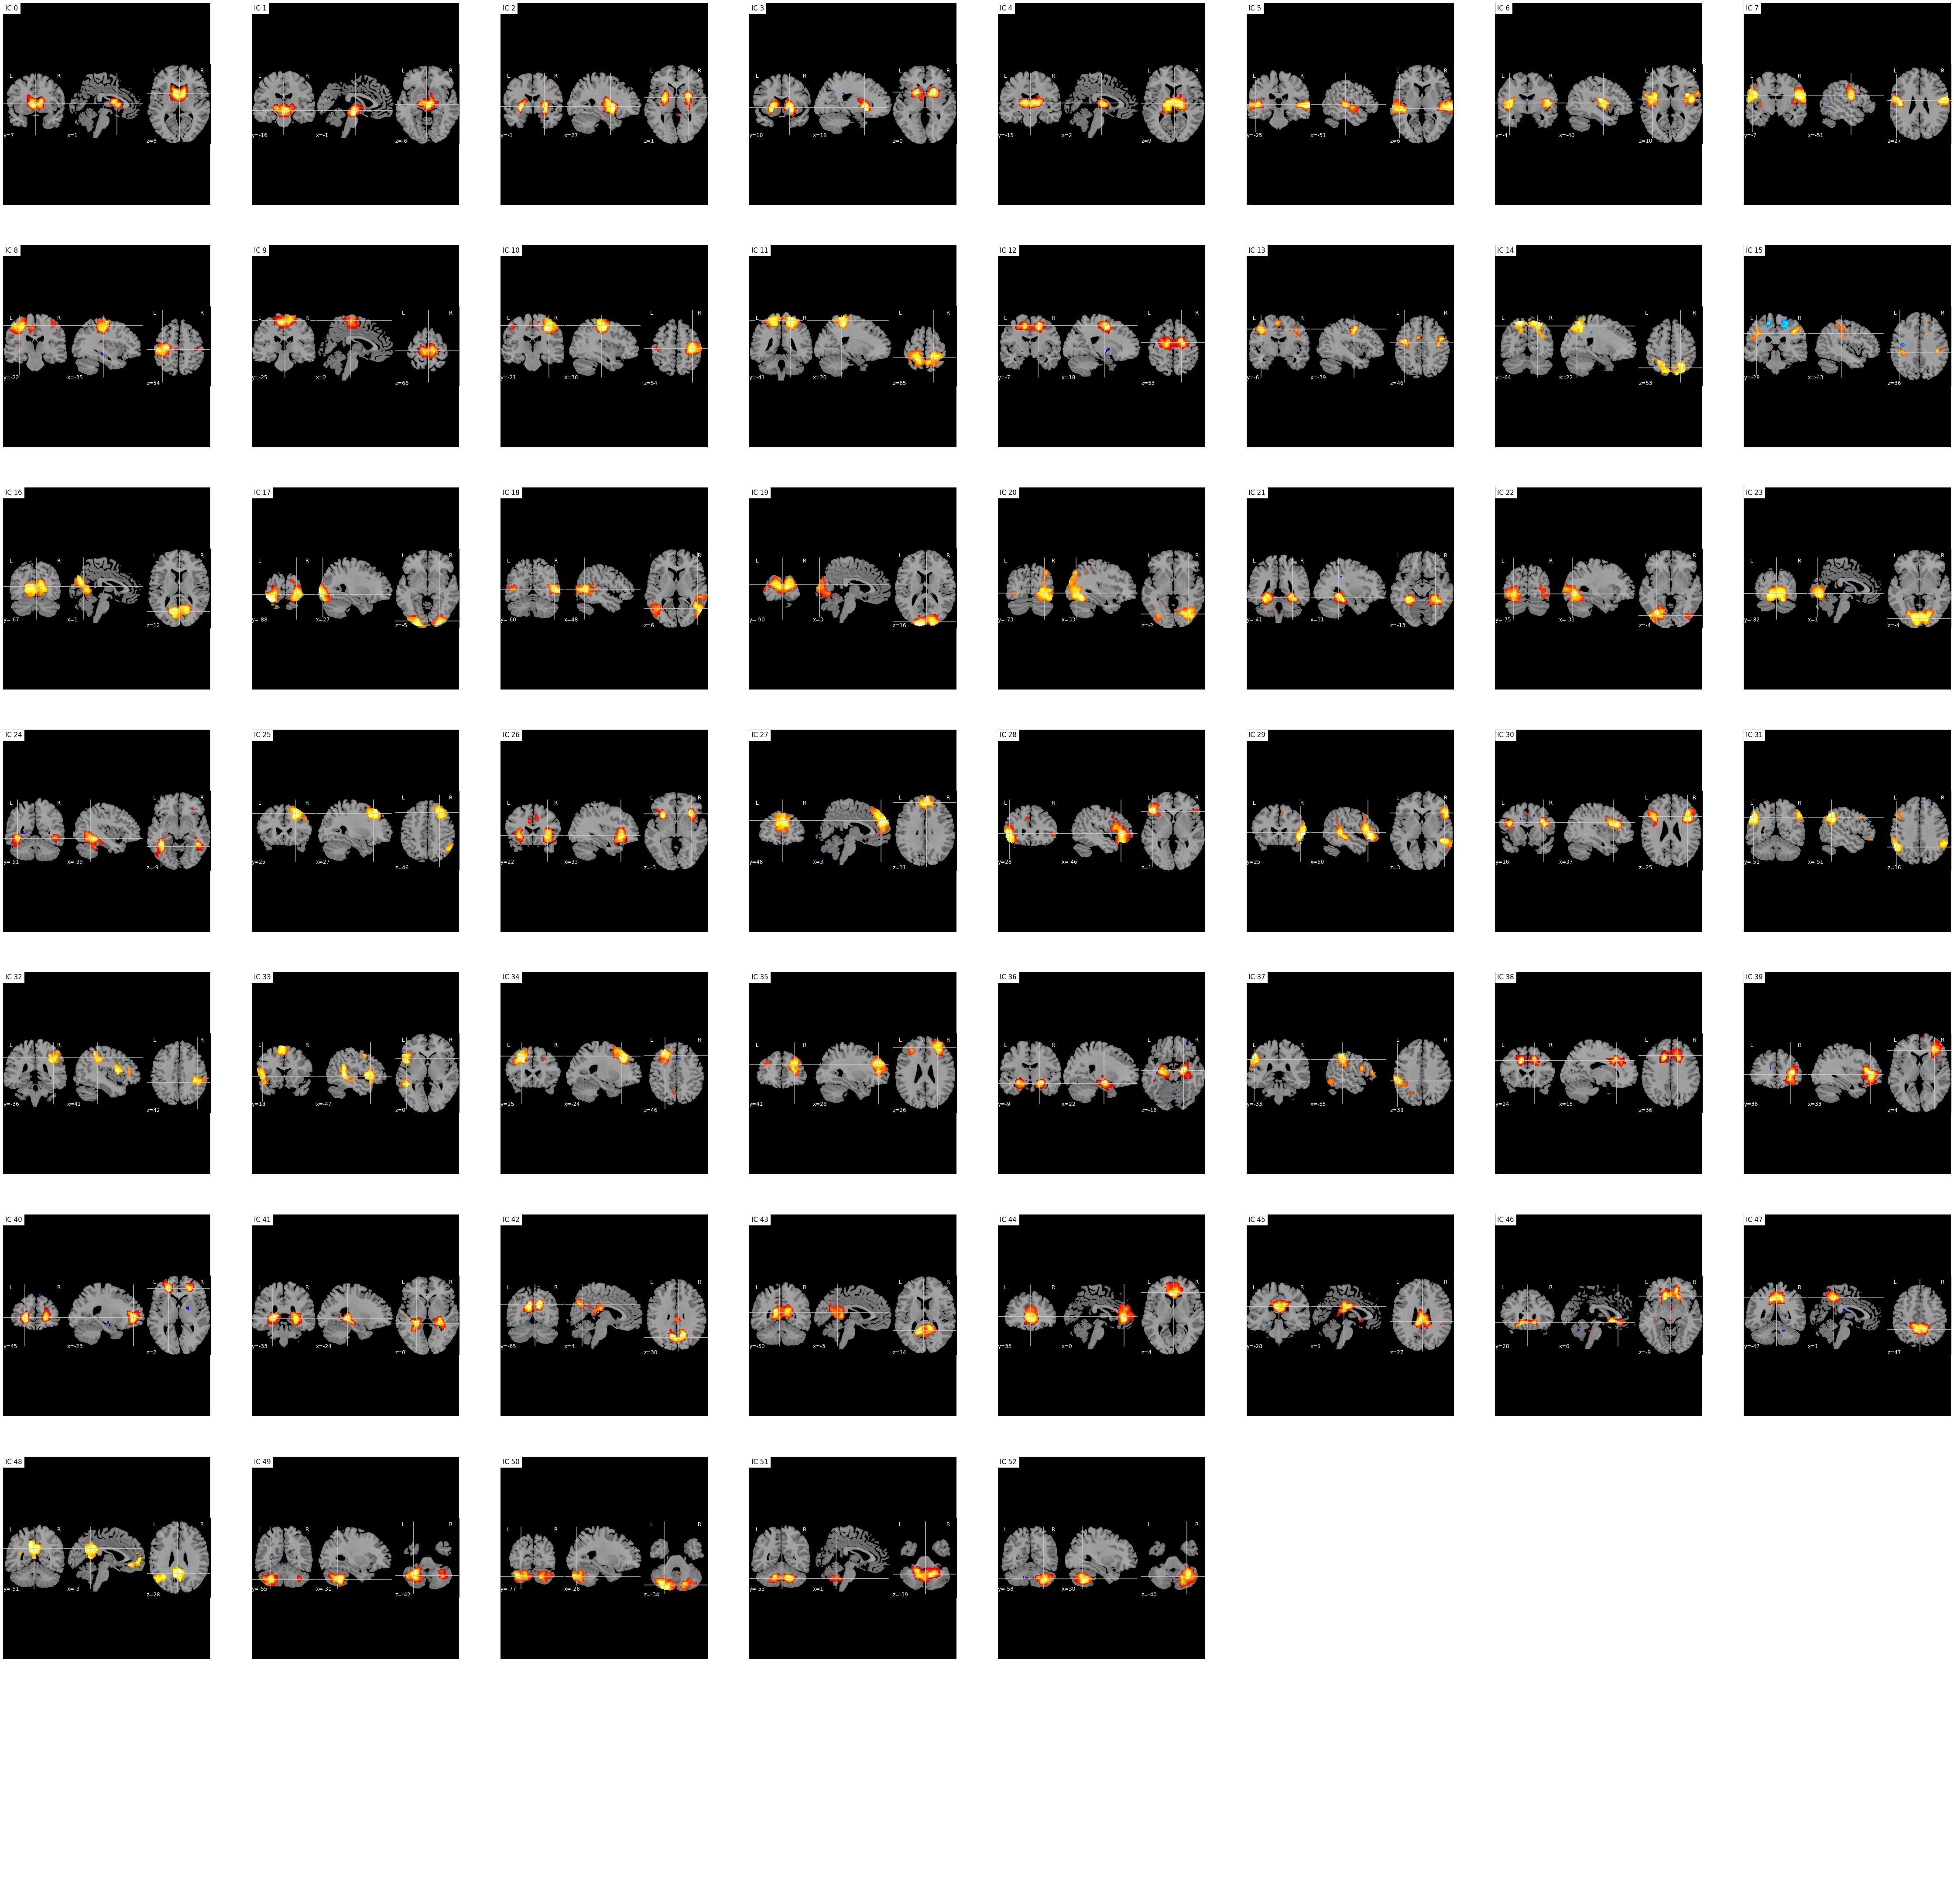

In [21]:
filename = random.choice(os.listdir(fMRI_train_data_path))
subject_filename = os.path.join(fMRI_train_data_path, filename)
subject_niimg = load_subject(subject_filename, mask_niimg)

grid_size = int(np.ceil(np.sqrt(53)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*10, grid_size*10))
[axi.set_axis_off() for axi in axes.ravel()]
row = -1 

for i, cur_img in enumerate(nl.image.iter_img(subject_niimg)):
    col = i % grid_size
    if col == 0:
        row += 1
    
    nlplt.plot_stat_map(cur_img,
                        bg_img=smri_filename,
                        title='IC %d' % i,
                        axes=axes[row, col],
                        threshold=3,
                        colorbar=False)

## <a href='#3'>Basic modelling</a>

For a basic modelling using SVM, I hhave used RAPIDS SVM as shown in Ahmet Erdem's kernel: https://www.kaggle.com/aerdem4/rapids-svm-on-trends-neuroimaging and used feature engineering from https://www.kaggle.com/jafarib/trends-eda-fe-submission

### <a href='#3-1'> Preparing data</a>

For this model, we will only be using basic features, and not the actual MRI image. As you'll see, the model works decently.

In [ ]:
# Loading 
fnc_df = pd.read_csv("../input/trends-assessment-prediction/fnc.csv")
loading_df = pd.read_csv("../input/trends-assessment-prediction/loading.csv")
labels_df = pd.read_csv("../input/trends-assessment-prediction/train_scores.csv")

fnc_features, loading_features = list(fnc_df.columns[1:]), list(loading_df.columns[1:])
df = fnc_df.merge(loading_df, on="Id")
labels_df["is_train"] = True

df = df.merge(labels_df, on="Id", how="left")

target_cols = ['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']

test_df = df[df["is_train"] != True].copy()
train_df = df[df["is_train"] == True].copy()

In [17]:
# Loading train scores
MAIN_DATA_PATH = '/media/hiroki/share/kaggle_data/trends-assessment-prediction/'

labels_df = pd.read_csv(MAIN_DATA_PATH + 'train_scores.csv')
loading_df = pd.read_csv(MAIN_DATA_PATH + 'loading.csv')
fnc_df = pd.read_csv(MAIN_DATA_PATH + 'fnc.csv')
svd_df = pd.read_csv(MAIN_DATA_PATH + 'image_svd_features.csv')

fnc_features, loading_features, svd_features  = list(fnc_df.columns[1:]), list(loading_df.columns[1:]), list(svd_df.columns[1:])
df = fnc_df.merge(loading_df, on="Id")
df = fnc_df.merge(svd_df, on="Id")
labels_df["is_train"] = True

df = df.merge(labels_df, on="Id", how="left")

target_cols = ['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']

test_df = df[df["is_train"] != True].copy()
train_df = df[df["is_train"] == True].copy()

In [18]:
y_train_df = train_df[target_cols]
train_df = train_df.drop(target_cols + ['is_train'], axis=1)
test_df = test_df.drop(target_cols + ['is_train'], axis=1)

FNC_SCALE = 1/500
test_df[fnc_features] *= FNC_SCALE
train_df[fnc_features] *= FNC_SCALE

In [19]:
train_df.head()

Id  SCN(53)_vs_SCN(69)  SCN(98)_vs_SCN(69)  SCN(99)_vs_SCN(69)  \
0  10001            0.000737            0.000334            0.000876   
1  10002            0.000303           -0.000050            0.000435   
3  10004            0.000266            0.000517            0.000982   
4  10005            0.000584            0.000503            0.000833   
6  10007            0.000047            0.000504            0.001143   

   SCN(45)_vs_SCN(69)  ADN(21)_vs_SCN(69)  ADN(56)_vs_SCN(69)  \
0            0.000682           -0.000373            0.000098   
1            0.000836           -0.000454           -0.000128   
3            0.000685            0.000182            0.000216   
4            0.001023           -0.000725           -0.000329   
6            0.000677           -0.000209           -0.000399   

   SMN(3)_vs_SCN(69)  SMN(9)_vs_SCN(69)  SMN(2)_vs_SCN(69)  ...  IC50_sv_2  \
0           0.000243          -0.000349          -0.000463  ... -17.799738   
1          -0.000288          -0.000236          -0.000110  ...   0.709199   
3           0.000058          -0.000052           0.000189  ...  -9.008883   
4          -0.000578          -0.000031          -0.000175  ...  12.041737   
6          -0.000482          -0.000382          -0.000057  ...   5.134978   

    IC51_sv_0  IC51_sv_1  IC51_sv_2   IC52_sv_0  IC52_sv_1  IC52_sv_2  \
0  166.031494   7.140522  -1.852221  162.160387  -7.110113 -13.135310   
1  163.013239  17.676404   5.821980  143.393550  -2.938574 -11.616378   
3  192.778342  -3.093821  -3.798846  175.548164  28.353885   2.312814   
4  178.219454  -8.466525  -8.717311  170.123615  -6.417135  -4.948467   
6  180.179770  15.868681   4.476608  159.916263   1.243108  -1.608821   

    IC53_sv_0  IC53_sv_1  IC53_sv_2  
0  174.460828 -42.337720 -12.991372  
1  160.541908  -4.967370  12.948171  
3  179.837870  26.207981 -35.805791  
4  180.774590 -21.734257  -1.682869  
6  179.713214 -30.641977  -4.577734  

[5 rows x 1538 columns]

In [20]:
test_df.head()

Id  SCN(53)_vs_SCN(69)  SCN(98)_vs_SCN(69)  SCN(99)_vs_SCN(69)  \
2   10003            0.000687            0.000220            0.001483   
5   10006            0.000647            0.000234            0.001281   
9   10010           -0.000453           -0.000087            0.000669   
10  10011            0.000335            0.000332            0.001042   
11  10012            0.001039            0.000594            0.001191   

    SCN(45)_vs_SCN(69)  ADN(21)_vs_SCN(69)  ADN(56)_vs_SCN(69)  \
2             0.001157           -0.001353           -0.000874   
5             0.000641           -0.000639           -0.000606   
9             0.000638           -0.000342           -0.000519   
10            0.000810           -0.000311           -0.000076   
11            0.001549           -0.001016           -0.000164   

    SMN(3)_vs_SCN(69)  SMN(9)_vs_SCN(69)  SMN(2)_vs_SCN(69)  ...  IC50_sv_2  \
2           -0.000591          -0.000756          -0.000690  ...  13.199830   
5           -0.000428          -0.000713          -0.000471  ...  31.788352   
9           -0.000279           0.000070           0.000181  ...  -7.542619   
10          -0.000104           0.000104           0.000174  ...   4.402735   
11           0.000077           0.000038           0.000344  ...  27.425245   

     IC51_sv_0  IC51_sv_1  IC51_sv_2   IC52_sv_0  IC52_sv_1  IC52_sv_2  \
2   174.917594  19.152848  -9.928726  169.786225  22.718672   0.167235   
5   149.021337  12.370486  37.468679  142.848266  29.108289  12.186597   
9   190.829387  63.303951 -10.683903  177.471958  -3.953985   7.453443   
10  176.593110  16.814323  13.351205  167.346241 -15.989412  -2.907931   
11  168.975699  -2.519493   4.657842  164.809378   3.752162   8.451581   

     IC53_sv_0  IC53_sv_1  IC53_sv_2  
2   164.056775   4.091340   2.155737  
5   150.882015  -0.153927  13.956243  
9   174.139657   5.815356  13.795921  
10   75.024373 -11.437069   0.285884  
11  180.592886 -33.029151   8.440923  

[5 rows x 1538 columns]

**We know that there is no data leakage between patients since each patient has a unique id.**

### <a href='#3-2'> Training</a>

In [21]:
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

In [22]:
param = {'objective':'regression',
        'metric':'rmse',
        'bossting_type':'gbdt',
        'learning_rate':0.01,
        'max_depth':-1}

output = pd.DataFrame()

for target in ['age','domain1_var1','domain1_var2','domain2_var1','domain2_var2']:
    
    X_train, X_val, y_train, y_val = train_test_split(train_df.iloc[:,1:], y_train_df[target], test_size=0.2, shuffle=True, random_state=20)
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    model = lgb.train(param, 
                      train_data, 
                      10000, 
                      early_stopping_rounds=15, 
                      valid_sets=[val_data], 
                      verbose_eval=50)
    
    temp = pd.DataFrame(test_df['Id'].apply(lambda x:str(x)+ '_'+ target))
    temp['Predicted'] = model.predict(test_df.iloc[:,1:])
    output = pd.concat([output,temp])

Training until validation scores don't improve for 15 rounds
[50]	valid_0's rmse: 13.2439
[100]	valid_0's rmse: 12.9647
[150]	valid_0's rmse: 12.7939
[200]	valid_0's rmse: 12.6816
[250]	valid_0's rmse: 12.593
[300]	valid_0's rmse: 12.5186
[350]	valid_0's rmse: 12.4624
[400]	valid_0's rmse: 12.4185
[450]	valid_0's rmse: 12.3742
[500]	valid_0's rmse: 12.3461
[550]	valid_0's rmse: 12.3259
[600]	valid_0's rmse: 12.3114
[650]	valid_0's rmse: 12.2986
Early stopping, best iteration is:
[664]	valid_0's rmse: 12.2903
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 17.6444
Training until validation scores don't improve for 15 rounds
[50]	valid_0's rmse: 20.2431
Early stopping, best iteration is:
[40]	valid_0's rmse: 20.2396
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 11.7545
Training until validation scores don't improve for 15 rounds
[50]	valid_0's rmse: 13

In [30]:
output.to_csv("svd_submission.csv", index=False)

In [24]:
sample_submission = pd.read_csv("add_svd_sub.csv")
output = sample_submission.drop('Predicted',axis=1).merge(output,on='Id',how='left')

FileNotFoundError: [Errno 2] File add_svd_sub.csv does not exist: 'add_svd_sub.csv'

## <a href="5-1">Submission - Ensemble</a>

In [29]:
sub_df = pd.read_csv("../input/trends-svc-rapids-ai/submission.csv")

In [30]:
final_sub = pd.DataFrame(data={
    'id':sample_submission['Id'],
    'Predicted': 0.7*output['Predicted'] + 0.3*sub_df['Predicted']
})

In [31]:
sub_df.to_csv("submission.csv", index=False)